## 範例重點

* 學習如何在 Keras 中加入自定義的 Callback
* 知道 Callback 每個動作的時機

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from keras import backend
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import Callback
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


## 準備資料

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
def normalize_cifar10_data(x, y):
    x = x.reshape((len(x), -1)) / 255.
    y = np_utils.to_categorical(y, num_classes=10)
    return x, y

def normalize_result(x, y):
    print('x.shape:', x.shape)
    print('y.shape:', y.shape)

In [4]:
print('Before normalization:')
normalize_result(X_train, y_train)

Before normalization:
x.shape: (50000, 32, 32, 3)
y.shape: (50000, 1)


In [5]:
print('After normalization:')
X_train, y_train = normalize_cifar10_data(X_train, y_train)
X_test, y_test = normalize_cifar10_data(X_test, y_test)
normalize_result(X_train, y_train)

After normalization:
x.shape: (50000, 3072)
y.shape: (50000, 10)


## 定義函數

In [6]:
class Trainer:

    def __init__(self, X_train, y_train, X_test, y_test, neuron_numbers=(512, 256, 128,),
                 epochs=50, batch_size=1024, momentum=0.95, learning_rate=1e-3):
        self.X_test = X_test
        self.y_test = y_test
        self.X_train = X_train
        self.y_train = y_train
        self.epochs = epochs
        self.batch_size = batch_size
        self.momentum = momentum
        self.learning_rate = learning_rate
        self.neuron_numbers = neuron_numbers
        self._model = None
        self._history = None

    @property
    def optimizer(self):
        return SGD(lr=self.learning_rate, momentum=self.momentum, nesterov=True)

    @property
    def callbacks(self):
        return [F1ScoreRecorder(self.training_data)]

    @property
    def training_data(self):
        return (self.X_train, self.y_train,)

    @property
    def validation_data(self):
        return (self.X_test, self.y_test,)

    def run(self):
        return self._clear()._build()._launch()

    def _clear(self):
        backend.clear_session()
        self._model = None
        return self

    def _build(self):
        main_input = hidden_input = Input(shape=self.X_train.shape[-1:], name='main_input')
        for i, neuron_number in enumerate(self.neuron_numbers):
            hidden_input = Dense(units=neuron_number, activation='relu', name=f'hidden_layer{i}')(hidden_input)
            hidden_input = BatchNormalization()(hidden_input)
        main_output = Dense(units=self.y_train.shape[-1], activation='softmax', name='main_output')(hidden_input)
        self._model = Model(inputs=[main_input], outputs=[main_output])
        self._model.compile(optimizer=self.optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        return self

    def _launch(self):
        print('Experiment with callback: {}'.format(F1ScoreRecorder.__name__))
        self._model.summary()
        self._history = self._model.fit(
            self.X_train, self.y_train, epochs=self.epochs, batch_size=self.batch_size,
            validation_data=self.validation_data, callbacks=self.callbacks, shuffle=True, verbose=2)
        return self

    def display(self, train_name, val_name):
        plt.figure(figsize=(8, 6,))
        plt.plot(self._history.history[train_name])
        plt.plot(self._history.history[val_name])
        plt.xlabel('Epoch')
        plt.ylabel(train_name)
        plt.title('Train History')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

class F1ScoreRecorder(Callback):

    def __init__(self, training_data):
        super().__init__()
        self.training_data = training_data

    def on_train_begin(self, logs=None):
        self.params['metrics'].extend(['f1', 'val_f1'])
    
    def on_epoch_end(self, epoch, logs=None):
        self._set_f1_score(*self.training_data[:2], 'f1', logs)
        self._set_f1_score(*self.validation_data[:2], 'val_f1', logs)
    
    def _set_f1_score(self, x, y, name, logs=None):
        logs[name] = f1_score(y.argmax(axis=1), self.model.predict(x).argmax(axis=1), average='weighted')

## 訓練模型

In [7]:
trainer = Trainer(X_train, y_train, X_test, y_test).run()

Experiment with callback: F1ScoreRecorder
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None

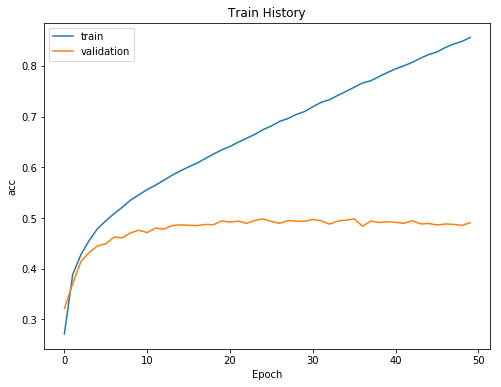

In [8]:
trainer.display('acc', 'val_acc')

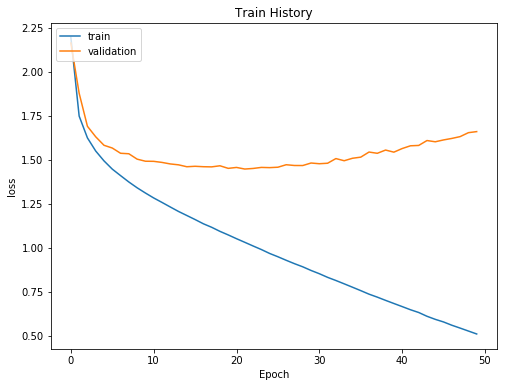

In [9]:
trainer.display('loss', 'val_loss')

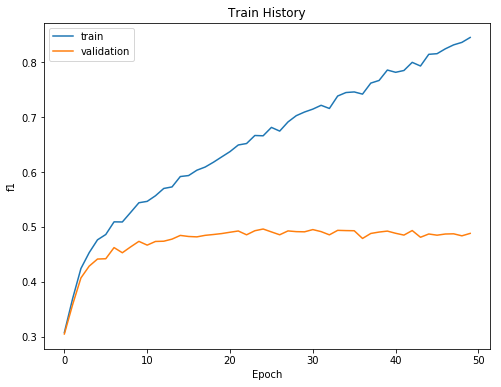

In [10]:
trainer.display('f1', 'val_f1')

## 作業

1. 請嘗試寫一個 callback 用來記錄在訓練過程中每次的 True Positive 與 True Negative。